# Multinomial Logistic Regression

## 1.1 - Dataset Analysis and Preprocessing

In [1]:
# import wandb
# import random

# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="solution-1",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 0.02,
#     "architecture": "CNN",
#     "dataset": "CIFAR-100",
#     "epochs": 10,
#     }
# )

# # simulate training
# epochs = 10
# offset = random.random() / 6
# for epoch in range(2, epochs):
#     acc = 1 - 2 ** -epoch - random.random() / epoch - offset
#     loss = 2 ** -epoch + random.random() / epoch + offset
    
#     # log metrics to wandb
#     wandb.log({"acc": acc, "loss": loss})

# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

wine_data = pd.read_csv('WineQT.csv')
wine_data = wine_data.drop(["Id"],axis=1)
colums = wine_data.columns
wine_data.head()
wine_data = np.array(wine_data)

In [3]:
# mean, standard deviation, min, and max values 

means = np.mean(wine_data, axis=0) # axis = 0 means column wise
stds = np.std(wine_data, axis=0)
mins = np.min(wine_data, axis=0)
maxs = np.max(wine_data, axis=0)

table = pd.DataFrame({"Features": colums ,"Mean": means, "Standard Deviation": stds, "Minimum": mins, "Maximum": maxs})
display(table)

,Features,Mean,Standard Deviation,Minimum,Maximum
0,fixed acidity,8.311111,1.746830,4.60000,15.90000
1,volatile acidity,0.531339,0.179555,0.12000,1.58000
2,citric acid,0.268364,0.196600,0.00000,1.00000
3,residual sugar,2.532152,1.355324,0.90000,15.50000
4,chlorides,0.086933,0.047247,0.01200,0.61100
5,free sulfur dioxide,15.615486,10.246001,1.00000,68.00000
6,total sulfur dioxide,45.914698,32.767787,6.00000,289.00000
7,density,0.996730,0.001924,0.99007,1.00369
8,pH,3.311015,0.156596,2.74000,4.01000
9,sulphates,0.657708,0.170324,0.33000,2.00000


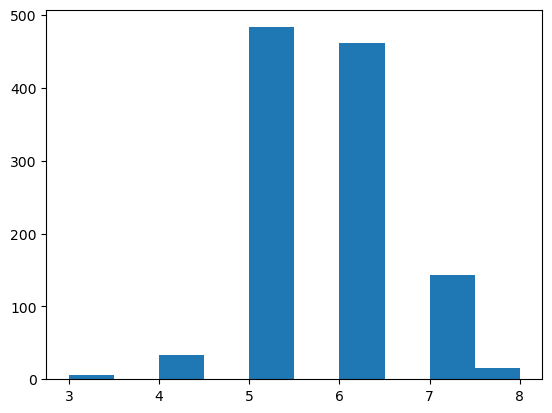

In [4]:
# freq distribution of the quality column

freq = wine_data[:,-1]
plt.hist(freq)
plt.show()

In [5]:
# Partition the dataset into train, validation, and test sets.
from sklearn.model_selection import train_test_split

X = wine_data[:, :-1]
y = wine_data[:, -1]

# y = y-3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# print("Training set shape: ", X_train.shape)
# print("Validation set shape: ", X_val.shape)
# print("Test set shape: ", X_test.shape)


In [6]:
# Normalise and standarize the data. Make sure to handle the missing or inconsistent data values if necessary.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

# output data is not scaled because we want to test the model on the original data


## 1.2 - Model Building from Scratch

In [7]:
# class for multinomial logistic regression
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
class MultiLogisticRegression:

    def __init__(self,Learning_Rate,Epochs):
        self.Learning_Rate = Learning_Rate
        self.Epochs = Epochs

    def fit(self, X, y):
        losses =[]
        accuracies = []
        accuracies_val = []
        self.classes = np.unique(y)
        self.features = X.shape[1]

        X_without_bias = X

        # add bias term i.e column of ones so that X is of form [1, x1, x2, x3, ...]
        X = np.insert(X, 0, 1, axis=1)

        # initialize weights, which represents contribution of each feature to each class
        self.weights = np.zeros((self.features + 1,len(self.classes))) # (n_features + 1) x n_classes

        # # make sum of weights in every row equal to 1
        # self.weights = self.weights / self.weights.sum(axis=1, keepdims=True)

        # one hot encode the target variable
        encoder = OneHotEncoder()
        encoded_y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

        # print(encoded_y)
        # gradient descent
        loss = 0
        for epoch in range(self.Epochs):

            # calculate probabilities
            z = np.dot(X, self.weights) # (n_examples x n_classes)

            # probs is prob of each class for each example
            probs = self.softmax(z) # (n_examples x n_classes)
            if epoch % 100 == 0:
                loss = self.log_loss(encoded_y, probs)
                losses.append([loss,epoch])
                acc = self.acc(y, self.predict(X_without_bias))
                accuracies.append([acc,epoch])
                acc_val = self.acc(y_val, self.predict(X_val_scaled))
                accuracies_val.append([acc_val,epoch])
                # print(f"Loss after epoch {epoch}: {loss}")
                # print(f"Accuracy after epoch {epoch} : {acc}")
                # print(f"Accuracy for val set after epoch {epoch} : {acc_val}")
                # print()
            
            # calculate gradient
            diff_matrix = probs - encoded_y # prob - y
            gradient = np.dot(X.T, diff_matrix)/len(y) # batch gradient descent

            # update weights
            self.weights -= self.Learning_Rate * gradient
        # print()
        # print(f"Loss after all itertions: {loss}")
        # print(f"Accuracy after all iteration : {self.acc(y, self.predict(X_without_bias))}")
        # print(f"Accuracy after all iteration for val set : {self.acc(y_val, self.predict(X_val_scaled))}")
        losses.append([loss,self.Epochs])
        accuracies.append([acc,self.Epochs])
        accuracies_val.append([acc_val,self.Epochs])
        return self.weights,losses,accuracies,accuracies_val

    def predict(self, X):
        # add bias term i.e column of ones so that X is of form [1, x1, x2, x3, ...]
        X = np.insert(X, 0, 1, axis=1)

        # calculate probabilities
        z = np.dot(X, self.weights)
        probs = self.softmax(z)

        # return class with highest probability
        return self.classes[np.argmax(probs, axis=1)]
    
    def softmax(self, z):
        # # subtract max value in each row from each element in that row to avoid overflow as exp(1000) is infinity in python
        # z -= np.max(z, axis=1, keepdims=True)

        # probs = np.zeros(z.shape)
        # for i in range(z.shape[0]):
        #     # calculate softmax for each row
        #     probs[i] = np.exp(z[i]) / np.sum(np.exp(z[i]))
        # return probs
    
        # faster way to calculate softmax
        exp_X = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_X / np.sum(exp_X, axis=1, keepdims=True)
    
    def log_loss(self, y, probs):
        epsilon = 1e-15
        probs = np.clip(probs, epsilon, 1 - epsilon)
        loss = -np.sum(y * np.log(probs)) / len(y)
        return loss
    
    def acc(self, y, y_pred):
        return accuracy_score(y, y_pred)


              precision    recall  f1-score   support

         4.0       1.00      0.00      0.00         4
         5.0       0.64      0.76      0.70        75
         6.0       0.61      0.62      0.61        81
         7.0       0.50      0.32      0.39        19
         8.0       1.00      0.00      0.00         4

    accuracy                           0.62       183
   macro avg       0.75      0.34      0.34       183
weighted avg       0.63      0.62      0.60       183



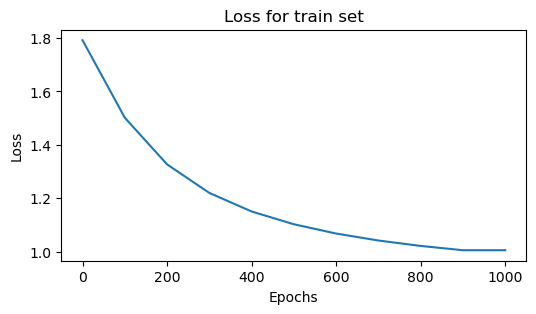

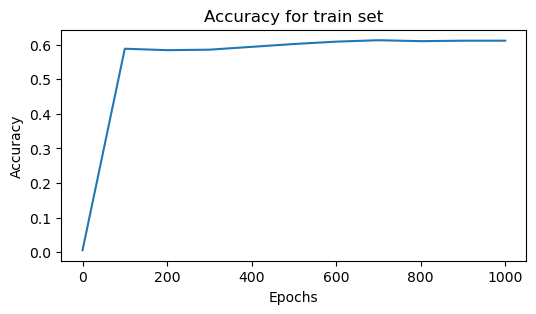

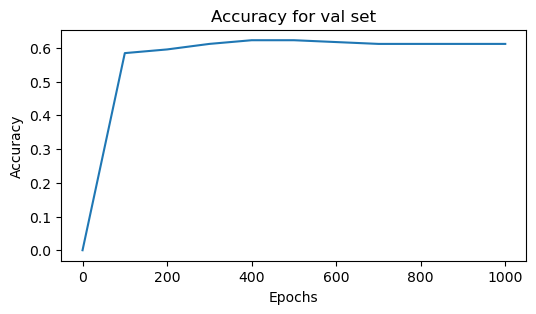

In [8]:

from sklearn.metrics import classification_report
import pandas as pd
# train the model
model = MultiLogisticRegression(0.01,1000)
model_fit = model.fit(X_train_scaled, y_train)

# make predictions
y_pred = model.predict(X_val_scaled)

# classification report
report = classification_report(y_val, y_pred,zero_division=1)
print(report)

# plot the loss curve
losses = np.array(model_fit[1])
plt.figure(figsize=(6, 3))
plt.plot(losses[:,1],losses[:,0])
plt.title("Loss for train set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# plot the accuracy curve
accuracies = np.array(model_fit[2])
plt.figure(figsize=(6, 3))
plt.plot(accuracies[:,1],accuracies[:,0])
plt.title("Accuracy for train set")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# plot the accuracy_val curve
accuracies_val = np.array(model_fit[3])
plt.figure(figsize=(6, 3))
plt.plot(accuracies_val[:,1],accuracies_val[:,0])
plt.title("Accuracy for val set")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


# # compare with sklearn's logistic regression
# from sklearn.linear_model import LogisticRegression

# # train the model
# model = LogisticRegression()
# model.fit(X_train_pca, y_train)

# # make predictions
# y_pred = model.predict(X_val_pca)

# # classification report
# report = classification_report(y_val, y_pred,zero_division=1)
# print(report)


### Hyperparameter Tuning

In [9]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guptayatharth1. Use `wandb login --relogin` to force relogin


True

In [10]:
wandb.init(
    project="logistic-regression",
)

In [11]:
# Initialize Weights & Biases Sweep
sweep_config = {
    'method': 'grid',  # You can choose different sweep methods (grid, random, etc.)
    'name': 'logistic_regression_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': {
        'lr': {'values': [0.001, 0.0001, 0.01, 0.05, 0.1, 0.5, 1]},  # Learning rate values to experiment with
        'num_epochs': {'values': [500, 1000, 2000, 5000, 10000]},  # Number of epochs to experiment with
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="logistic-regression")

Create sweep with ID: v0y75vhi
Sweep URL: https://wandb.ai/guptayatharth1/logistic-regression/sweeps/v0y75vhi


In [12]:
# Hyperparameter tuning

def train():
    # Initialize Weights & Biases run
    with wandb.init() as run:
        # Configure the logistic regression model with hyperparameters
        config = run.config
        logistic_regression = MultiLogisticRegression(config.lr, config.num_epochs)

        # Fit the model
        logistic_regression.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        y_pred = logistic_regression.predict(X_val_scaled)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)

        # Log the hyperparameters and accuracy to the current run
        wandb.log({"val_accuracy": accuracy})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()



# learning_rates = [0.01, 0.05, 0.1, 0.5, 1]
# epochs = [500, 1000, 1500, 2000]
# best_acc = 0
# best_lr = 0
# best_epoch = 0
# for lr in learning_rates:
#     for epoch in epochs:
#         model = MultiLogisticRegression(lr, epoch)
#         model_fit = model.fit(X_train_scaled, y_train)
#         acc = model.acc(y_val, model.predict(X_val_scaled))
#         if acc > best_acc:
#             best_acc = acc
#             best_lr = lr
#             best_epoch = epoch
#         print(f"Learning Rate: {lr}, Epochs: {epoch}, Accuracy: {acc}")
# print()
# print(f"Best Learning Rate: {best_lr}, Best Epochs: {best_epoch}, Best Accuracy: {best_acc}")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: uxpvhdqf with config:
wandb: 	lr: 0.001
wandb: 	num_epochs: 500


val_accuracy,▁
val_accuracy,0.5847


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 300, in check_internal_messages
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 286, in check_stop_status
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._loo

val_accuracy,▁
val_accuracy,0.5847


wandb: Agent Starting Run: n12u55be with config:
wandb: 	lr: 0.001
wandb: 	num_epochs: 2000


val_accuracy,▁
val_accuracy,0.59563


wandb: Agent Starting Run: n0s4uaao with config:
wandb: 	lr: 0.001
wandb: 	num_epochs: 5000


val_accuracy,▁
val_accuracy,0.62295


wandb: Agent Starting Run: wyq69ci1 with config:
wandb: 	lr: 0.001
wandb: 	num_epochs: 10000


val_accuracy,▁
val_accuracy,0.61749


wandb: Agent Starting Run: 78781sck with config:
wandb: 	lr: 0.0001
wandb: 	num_epochs: 500


val_accuracy,▁
val_accuracy,0.59016


wandb: Agent Starting Run: kces14yc with config:
wandb: 	lr: 0.0001
wandb: 	num_epochs: 1000


val_accuracy,▁
val_accuracy,0.59016


wandb: Agent Starting Run: z9sslhc9 with config:
wandb: 	lr: 0.0001
wandb: 	num_epochs: 2000


val_accuracy,▁
val_accuracy,0.59563


wandb: Agent Starting Run: 8asvfbg3 with config:
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5000


val_accuracy,▁
val_accuracy,0.5847


wandb: Agent Starting Run: cwh13oef with config:
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10000


val_accuracy,▁
val_accuracy,0.5847


wandb: Agent Starting Run: kgrv5ulo with config:
wandb: 	lr: 0.01
wandb: 	num_epochs: 500


val_accuracy,▁
val_accuracy,0.62295


wandb: Agent Starting Run: e9v5xawq with config:
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000


val_accuracy,▁
val_accuracy,0.61749


wandb: Agent Starting Run: 9py8um6e with config:
wandb: 	lr: 0.01
wandb: 	num_epochs: 2000


val_accuracy,▁
val_accuracy,0.61749


wandb: Agent Starting Run: 21otcjaq with config:
wandb: 	lr: 0.01
wandb: 	num_epochs: 5000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: lzz7s0qd with config:
wandb: 	lr: 0.01
wandb: 	num_epochs: 10000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: rgmeljmt with config:
wandb: 	lr: 0.05
wandb: 	num_epochs: 500


val_accuracy,▁
val_accuracy,0.61749


wandb: Agent Starting Run: ocuwavvy with config:
wandb: 	lr: 0.05
wandb: 	num_epochs: 1000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: wtqm3uoz with config:
wandb: 	lr: 0.05
wandb: 	num_epochs: 2000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: an7wrgrt with config:
wandb: 	lr: 0.05
wandb: 	num_epochs: 5000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: wro0nmc4 with config:
wandb: 	lr: 0.05
wandb: 	num_epochs: 10000


val_accuracy,▁
val_accuracy,0.60656


wandb: Agent Starting Run: myydq3pf with config:
wandb: 	lr: 0.1
wandb: 	num_epochs: 500


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: tzgsahja with config:
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: z3lzitg7 with config:
wandb: 	lr: 0.1
wandb: 	num_epochs: 2000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: om0w5i9c with config:
wandb: 	lr: 0.1
wandb: 	num_epochs: 5000


val_accuracy,▁
val_accuracy,0.60656


wandb: Agent Starting Run: 3zz5p8b0 with config:
wandb: 	lr: 0.1
wandb: 	num_epochs: 10000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: b0f8q47s with config:
wandb: 	lr: 0.5
wandb: 	num_epochs: 500


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: y4irsona with config:
wandb: 	lr: 0.5
wandb: 	num_epochs: 1000


val_accuracy,▁
val_accuracy,0.60656


wandb: Agent Starting Run: ik1i0f5b with config:
wandb: 	lr: 0.5
wandb: 	num_epochs: 2000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: s4fy69a1 with config:
wandb: 	lr: 0.5
wandb: 	num_epochs: 5000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: 2e9xi0xw with config:
wandb: 	lr: 0.5
wandb: 	num_epochs: 10000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: pnjburgg with config:
wandb: 	lr: 1
wandb: 	num_epochs: 500


val_accuracy,▁
val_accuracy,0.60656


wandb: Agent Starting Run: xylvkrol with config:
wandb: 	lr: 1
wandb: 	num_epochs: 1000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: hgm95lf2 with config:
wandb: 	lr: 1
wandb: 	num_epochs: 2000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: 3txhk4eb with config:
wandb: 	lr: 1
wandb: 	num_epochs: 5000


val_accuracy,▁
val_accuracy,0.60109


wandb: Agent Starting Run: vdij949x with config:
wandb: 	lr: 1
wandb: 	num_epochs: 10000


val_accuracy,▁
val_accuracy,0.60109


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f4d940ac940>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [9]:
from sklearn.metrics import classification_report
# evaluate the model on the test set and print classification report
best_lr = 0.05
best_epoch = 1000

model = MultiLogisticRegression(best_lr, best_epoch)
model_fit = model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
report = classification_report(y_test, y_pred,zero_division=1)
print(report)


              precision    recall  f1-score   support

         3.0       1.00      0.00      0.00         2
         4.0       1.00      0.00      0.00         8
         5.0       0.68      0.76      0.72        95
         6.0       0.60      0.64      0.62        91
         7.0       0.50      0.43      0.46        30
         8.0       1.00      0.00      0.00         3

    accuracy                           0.62       229
   macro avg       0.80      0.30      0.30       229
weighted avg       0.64      0.62      0.60       229

